In [1]:
""" %pip install pandas
%pip install numpy
%pip install scikit-learn
%pip install seaborn
%pip install matplotlib
%pip install skorch #for wrapping pytorch models in sklearn
 """

' %pip install pandas\n%pip install numpy\n%pip install scikit-learn\n%pip install seaborn\n%pip install matplotlib\n%pip install skorch #for wrapping pytorch models in sklearn\n '

In [2]:
import pandas as pd
import numpy as np

In [3]:
dynamic_data = pd.read_csv('sph_dynamic.csv')

In [4]:
static_data = pd.read_csv('sph_static.csv')

In [5]:
# Missing Values in Dynamic Table
dynamic_data.isnull().sum()

stay_id                   0
charttime                 0
total_protein          6930
calcium                 933
creatinine              261
glucose                 444
sodium                  214
chloride                241
heart_rate             6833
sbp                    6895
dbp                    6895
mbp                    6887
resp_rate              6832
temperature            6974
hemoglobin             1179
wbc                    1207
alt                    3964
ast                    3936
alp                    3976
bilirubin_total        3957
bilirubin_direct       6808
bilirubin_indirect     6812
ph                     7004
lactate                7012
pt                     3068
urineoutput            6942
sofa_respiration       7005
sofa_coagulation       7023
sofa_liver             7023
sofa_cardiovascular    6872
sofa_cns               6979
sofa_renal             7024
dtype: int64

In [6]:
# Drop the columns with more than 80%
for col in dynamic_data.columns:
    if dynamic_data[col].isnull().sum() > len(dynamic_data)*0.8:
        del dynamic_data[col]

In [7]:
dynamic_data.isnull().sum()

stay_id               0
charttime             0
calcium             933
creatinine          261
glucose             444
sodium              214
chloride            241
hemoglobin         1179
wbc                1207
alt                3964
ast                3936
alp                3976
bilirubin_total    3957
pt                 3068
dtype: int64

In [8]:
# ['alt','ast','alp','bilirubin_total','pt'] are liver function related test results
# create a new binary column 'liver_function_test', True/1 means have ever taken liver function test
liver_test_result = ['alt','ast','alp','bilirubin_total','pt']
def liver_categorize(group):
    flag = True
    for i in liver_test_result:
        if group[i].notnull().any():
            flag = False
    if flag:
        group['liver_function_test'] = False
    else:
        group['liver_function_test'] = True
    return group

dynamic_data = dynamic_data.groupby('stay_id').apply(liver_categorize)

C:\Users\Mervin\AppData\Local\Temp\ipykernel_2680\240455136.py:15: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  dynamic_data = dynamic_data.groupby('stay_id').apply(liver_categorize)


In [9]:
dynamic_data

,stay_id,charttime,calcium,creatinine,glucose,sodium,chloride,hemoglobin,wbc,alt,ast,alp,bilirubin_total,pt,liver_function_test
0,35715575,2148-12-27 18:15:00.000,8.5,0.9,137.0,138.0,104.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
1,34483718,2118-01-04 03:58:00.000,8.2,0.8,129.0,141.0,101.0,8.7,11.3,NaN,NaN,NaN,NaN,12.1,True
2,31826892,2163-03-10 19:59:00.000,7.7,0.4,112.0,136.0,98.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
3,36154799,2131-12-02 19:14:00.000,NaN,NaN,NaN,NaN,NaN,12.3,NaN,NaN,NaN,NaN,NaN,NaN,True
4,32732521,2116-08-12 12:45:00.000,NaN,4.0,135.0,139.0,105.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7019,31292653,2192-03-18 03:14:00.000,NaN,1.4,102.0,137.0,103.0,8.7,4.9,NaN,NaN,NaN,NaN,NaN,True
7020,32964221,2127-01-30 10:00:00.000,8.6,0.5,112.0,139.0,107.0,8.9,14.3,14.0,32.0,148.0,2.6,NaN,True
7021,33493321,2142-07-28 06:02:00.000,NaN,1.1,130.0,142.0,105.0,8.4,4.0,NaN,NaN,NaN,NaN,NaN,True
7022,38658392,2189-05-17 00:13:00.000,7.3,1.0,174.0,133.0,93.0,13.0,19.5,9.0,18.0,48.0,0.5,13.0,True


In [10]:
dynamic_data.describe()

,stay_id,calcium,creatinine,glucose,sodium,chloride,hemoglobin,wbc,alt,ast,alp,bilirubin_total,pt
count,7.024000e+03,6091.000000,6763.000000,6580.000000,6810.000000,6783.000000,5845.000000,5817.000000,3060.000000,3088.000000,3048.000000,3067.000000,3956.000000
mean,3.497892e+07,8.389640,1.644019,142.289666,137.309545,102.067079,10.043353,10.973130,161.859150,243.882772,131.933727,4.248745,18.826567
std,2.832325e+06,0.820066,1.839893,89.875986,5.638384,6.731008,2.177573,8.228807,752.898832,1216.527439,123.088598,7.808056,11.588015
min,3.000414e+07,4.200000,0.100000,30.000000,83.000000,62.000000,3.900000,0.100000,1.000000,5.000000,7.000000,0.100000,9.200000
25%,3.255070e+07,7.900000,0.800000,102.000000,134.000000,98.000000,8.400000,5.900000,17.000000,22.000000,65.000000,0.500000,12.800000
50%,3.496990e+07,8.400000,1.100000,125.000000,138.000000,102.000000,9.800000,9.400000,30.000000,42.000000,92.000000,1.000000,14.900000
75%,3.746081e+07,8.900000,1.800000,159.000000,141.000000,106.000000,11.400000,14.200000,62.000000,95.000000,149.000000,3.600000,20.400000
max,3.999217e+07,12.300000,19.700000,2970.000000,185.000000,153.000000,18.400000,125.200000,15018.000000,28275.000000,1185.000000,52.600000,150.000000


In [11]:
# Assume that patients with no relevant results recorded don't have liver issues
# so we impute these patients' missing values of these columns with random number in normal range

# but i can not find the unit and normal range for them so i drop them first >_<
# dynamic_data.drop(['alt','ast','alp','bilirubin_total','pt'], axis = 1, inplace = True)

In [12]:
dynamic_data.isnull().sum()

stay_id                   0
charttime                 0
calcium                 933
creatinine              261
glucose                 444
sodium                  214
chloride                241
hemoglobin             1179
wbc                    1207
alt                    3964
ast                    3936
alp                    3976
bilirubin_total        3957
pt                     3068
liver_function_test       0
dtype: int64

In [13]:
print(dynamic_data.loc[dynamic_data['liver_function_test']==False, 'alt'].describe())
print(dynamic_data.loc[dynamic_data['liver_function_test']==False, 'ast'].describe())
print(dynamic_data.loc[dynamic_data['liver_function_test']==False, 'alp'].describe())
print(dynamic_data.loc[dynamic_data['liver_function_test']==False, 'bilirubin_total'].describe())
print(dynamic_data.loc[dynamic_data['liver_function_test']==False, 'pt'].describe())

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: alt, dtype: float64
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: ast, dtype: float64
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: alp, dtype: float64
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: bilirubin_total, dtype: float64
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: pt, dtype: float64


In [14]:
# use KNN to impute the rest
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors = 10)
dynamic_data.iloc[:,2:] = imputer.fit_transform(dynamic_data.iloc[:,2:])

In [15]:
# define normal ranges for each column
normal_ranges = {
    'alt': (5, 40),
    'ast': (10, 35),
    'alp': (40, 130),
    'bilirubin_total': (0.1, 1.0),
    'pt': (9.5, 13.5)
}

In [16]:
mask = dynamic_data['liver_function_test'] == False
n_no_test = mask.sum()
def sample_normal(col):
    lower = normal_ranges[col][0]
    upper = normal_ranges[col][1]
    return np.random.normal(loc=(lower+upper)/2, scale=(upper-lower)/6, size=n_no_test)

sampled_alt = sample_normal("alt")
sampled_ast = sample_normal("ast")
sampled_alp = sample_normal("alp")
sampled_bilirubin_total = sample_normal("bilirubin_total")
sampled_pt = sample_normal("pt")
dynamic_data.loc[mask, 'alt'] = sampled_alt
dynamic_data.loc[mask, 'ast'] = sampled_ast
dynamic_data.loc[mask, 'alp'] = sampled_alp
dynamic_data.loc[mask, 'bilirubin_total'] = sampled_bilirubin_total
dynamic_data.loc[mask, 'pt'] = sampled_pt

In [17]:
print(dynamic_data.loc[dynamic_data['liver_function_test']==False, 'alt'].describe())
print(dynamic_data.loc[dynamic_data['liver_function_test']==False, 'ast'].describe())
print(dynamic_data.loc[dynamic_data['liver_function_test']==False, 'alp'].describe())
print(dynamic_data.loc[dynamic_data['liver_function_test']==False, 'bilirubin_total'].describe())
print(dynamic_data.loc[dynamic_data['liver_function_test']==False, 'pt'].describe())

count    349.000000
mean      22.322735
std        5.704281
min        6.452952
25%       18.397575
50%       21.789975
75%       26.564911
max       38.753696
Name: alt, dtype: float64
count    349.000000
mean      22.418722
std        3.818373
min       11.547158
25%       20.050159
50%       22.413922
75%       24.943593
max       31.478248
Name: ast, dtype: float64
count    349.000000
mean      84.950863
std       15.755805
min       44.231031
25%       73.380964
50%       85.609513
75%       96.379514
max      122.632505
Name: alp, dtype: float64
count    349.000000
mean       0.545112
std        0.161028
min        0.088599
25%        0.433105
50%        0.546973
75%        0.646089
max        1.005938
Name: bilirubin_total, dtype: float64
count    349.000000
mean      11.503562
std        0.618739
min        9.453288
25%       11.051869
50%       11.454811
75%       11.937679
max       13.241363
Name: pt, dtype: float64


In [18]:
#to address the same patinent have differrent results at the same charttime
dynamic_data = dynamic_data.groupby(['stay_id','charttime']).mean().reset_index()

In [19]:
#compute the gradient
def count_gradient(group):
    testresult = list(dynamic_data.columns)[2:-1]
    for i in testresult:
        if len(group) == 1:
            group[i+'_grad'] = 0
        else:
            time_diff = (group['charttime'].iloc[-1] - group['charttime'].iloc[-2]).total_seconds()
            group[i+'_grad'] = (group[i].iloc[-1] - group[i].iloc[-2]) / time_diff 
    return group

In [20]:
dynamic_data['charttime'] = pd.to_datetime(dynamic_data['charttime'])

In [21]:
dynamic_data.sort_values(by = ['stay_id','charttime'], inplace = True)
dynamic_data = dynamic_data.groupby('stay_id').apply(count_gradient)

C:\Users\Mervin\AppData\Local\Temp\ipykernel_2680\3194640149.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  dynamic_data = dynamic_data.groupby('stay_id').apply(count_gradient)


In [22]:
# take the last values of all timepoints for each patient
dynamic_data_last = dynamic_data.drop(['charttime'],axis = 1).groupby('stay_id').tail(1)

In [23]:
# merge dynamic and static table
data = static_data.merge(dynamic_data_last, on = 'stay_id')

In [24]:
data

,stay_id,icu_intime,vent_start,vent_end,vent_duration,calcium,creatinine,glucose,sodium,chloride,...,glucose_grad,sodium_grad,chloride_grad,hemoglobin_grad,wbc_grad,alt_grad,ast_grad,alp_grad,bilirubin_total_grad,pt_grad
0,30004144,2126-04-04 13:20:25.000,4/5/26 16:00,4/6/26 17:00,25.000000,6.80,0.7,133.0,135.0,102.0,...,0.001466,0.000000,-0.000077,-0.000093,-0.000023,-0.000216,-0.001782,0.002238,0.000002,0.000093
1,30005366,2202-12-27 17:36:59.000,12/28/02 14:00,12/28/02 20:00,6.000000,8.80,6.7,41.0,139.0,100.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,30006983,2159-10-12 03:56:42.000,10/12/59 18:00,10/14/59 19:00,49.000000,7.10,1.0,89.0,136.0,108.0,...,-0.001230,0.000073,0.000110,-0.000015,0.000022,0.000055,0.000275,-0.000606,0.000004,0.000031
3,30023204,2124-07-09 16:43:55.000,7/11/24 16:00,7/12/24 16:10,24.166667,8.50,1.4,107.0,131.0,100.0,...,0.000403,-0.000050,-0.000201,0.000076,-0.000222,0.002110,0.001334,0.000534,-0.000062,-0.000226
4,30031418,2156-03-05 14:11:00.000,3/7/56 22:06,3/8/56 8:00,9.900000,7.40,0.4,133.0,139.0,106.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1918,39977971,2115-12-11 17:42:45.000,12/12/15 12:00,12/12/15 16:00,4.000000,8.90,2.2,98.0,132.0,97.0,...,-0.003474,0.000100,0.000033,-0.000037,-0.000017,-0.002295,0.000852,-0.000658,-0.000005,0.000010
1919,39982332,2180-03-01 22:35:04.000,3/2/80 19:00,3/3/80 8:00,13.000000,8.82,1.2,119.0,140.0,103.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1920,39985110,2141-03-03 05:57:46.000,3/4/41 20:44,3/6/41 4:00,31.266667,10.40,6.8,149.0,139.0,98.0,...,0.000425,0.000018,0.000000,0.000007,0.000052,0.000575,0.000778,-0.001323,0.000013,0.000032
1921,39986206,2183-06-19 23:25:31.000,6/20/83 22:00,6/30/83 4:00,222.000000,7.50,6.0,101.0,139.0,103.0,...,-0.000866,0.000000,0.000000,0.000017,-0.000039,0.002264,0.002580,0.003697,0.000011,0.000013


In [25]:
#Converting data type of icu_intime, vent_start and vent_end to date and time format
data['icu_intime'] = pd.to_datetime(data['icu_intime'])
data['vent_start'] = pd.to_datetime(data['vent_start'], format='%m/%d/%y %H:%M')
data['vent_end'] = pd.to_datetime(data['vent_end'], format='%m/%d/%y %H:%M')

In [26]:
data.dtypes

stay_id                          int64
icu_intime              datetime64[ns]
vent_start              datetime64[ns]
vent_end                datetime64[ns]
vent_duration                  float64
calcium                        float64
creatinine                     float64
glucose                        float64
sodium                         float64
chloride                       float64
hemoglobin                     float64
wbc                            float64
alt                            float64
ast                            float64
alp                            float64
bilirubin_total                float64
pt                             float64
liver_function_test            float64
calcium_grad                   float64
creatinine_grad                float64
glucose_grad                   float64
sodium_grad                    float64
chloride_grad                  float64
hemoglobin_grad                float64
wbc_grad                       float64
alt_grad                 

In [27]:
# Categorize vent_duration 
data['vent_duration_category'] = pd.cut(data['vent_duration'], bins=[0,4,8,12,16,20,24,36,48,72,np.inf],
                                         labels=['0-4 hours', '4-8 hours', '8-12 hours', '12-16 hours',
                                                 '16-20 hours', '20-24 hours', '24-36 hours', '36-48 hours',
                                                 '48-72 hours','over 72 hours'])
data['vent_duration_category'].value_counts()

over 72 hours    294
4-8 hours        249
8-12 hours       217
12-16 hours      203
24-36 hours      194
16-20 hours      182
0-4 hours        158
48-72 hours      155
36-48 hours      148
20-24 hours      123
Name: vent_duration_category, dtype: int64

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
#Dropped icu_intime, vent_start and vent_end as they are usable for correlation
#Creating correlation matrix to observe the relationship between variables
df_corr = data.loc[:,'vent_duration':'pt_grad'].corr()

#Setting up plots
#f, ax = plt.subplots(figsize=(12,10))

#Setting up lower triangle correlation matrix
#mask = np.triu(np.ones(df_corr.shape), k=0).astype(bool)
#cmap = sns.diverging_palette(220, 20, as_cmap=True)
#sns.heatmap(df_corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)


In [29]:
#Plotting pairplot to assess the relationship and distribution of each variable. 
#sns.pairplot(data.loc[:,'vent_duration':'pt'])

In [30]:
from sklearn.preprocessing import StandardScaler

# Select only numeric columns
numeric_cols = data.select_dtypes(include=np.number).columns.tolist()

# Scale the numeric columns using StandardScaler
scaler = StandardScaler()
scaled_df = scaler.fit_transform(data[numeric_cols])

# Create a new dataframe with the scaled numeric columns
scaled_df = pd.DataFrame(scaled_df, columns=numeric_cols, index=data.index)

# Identify outliers with z-scores greater than 2.5 or less than -2.5 (95%)
z_scores = (scaled_df - scaled_df.mean()) / scaled_df.std()
outliers = data[(z_scores > 2.5).any(axis=1) | (z_scores < -2.5).any(axis=1)]

# Remove outliers from the original dataframe
trimmed_df = data.drop(outliers.index)

print("Original Shape:", data.shape)
print("Trimmed Shape:", trimmed_df.shape)
#print(sns.pairplot(trimmed_df.loc[:,'vent_duration':'pt']))

Original Shape: (1923, 31)
Trimmed Shape: (1296, 31)


In [31]:
#Creating correlation matrix to observe the relationship between variables
trimmed_df_corr = trimmed_df.loc[:,'vent_duration':'pt_grad'].corr()


## Splitting Data Set

In [32]:
from sklearn.model_selection import train_test_split
# Splitting Datasets into Train and Test
X= data.drop(['stay_id', 'icu_intime', 'vent_start', 'vent_end','vent_duration', 'vent_duration_category'], axis=1)
y= data['vent_duration_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #Split to train & test set (8:2)

In [33]:
# The dimension of the training set
print("X_train:",X_train.shape)
print("y_train:",y_train.shape)

# The dimension of the test set
print("X_test:",X_test.shape)
print("y_test:",y_test.shape)

X_train: (1538, 25)
y_train: (1538,)
X_test: (385, 25)
y_test: (385,)


## Normalising Dataset after splitting

In [34]:
from sklearn.preprocessing import MinMaxScaler
# Calculate the normalization parameters on the training set
scaler = MinMaxScaler()
scaler.fit(X_train)

# Normalize the training set using the calculated parameters
X_train_norm = scaler.transform(X_train)
X_train_norm_df = pd.DataFrame(X_train_norm, columns=X_train.columns)

# Normalize the test set using the same normalization parameters as the training set
X_test_norm = scaler.transform(X_test)
X_test_norm_df = pd.DataFrame(X_test_norm, columns=X_test.columns)

# Verify that the mean and standard deviation of the training and test sets are similar
print("Training set mean: ", np.mean(X_train_norm))
print("Training set std: ", np.std(X_train_norm))
print("Test set mean: ", np.mean(X_test_norm))
print("Test set std: ", np.std(X_test_norm))

Training set mean:  0.3995145255507676
Training set std:  0.36955481888088537
Test set mean:  0.40121762017517903
Test set std:  0.3699436336238242


## Feature Selection Using Recursive Feature Selection

In [35]:
# listing columns
print(X_train_norm_df)
print(y_train)

       calcium  creatinine   glucose    sodium  chloride  hemoglobin  \
0     0.515625    0.087629  0.229541  0.422535  0.414634    0.379577   
1     0.421875    0.061856  0.173653  0.535211  0.548780    0.373239   
2     0.531250    0.041237  0.165669  0.450704  0.426829    0.612676   
3     0.359375    0.025773  0.207585  0.422535  0.439024    0.549296   
4     0.468750    0.036082  0.187625  0.464789  0.451220    0.429577   
...        ...         ...       ...       ...       ...         ...   
1533  0.359375    0.067010  0.219561  0.478873  0.426829    0.619718   
1534  0.546875    0.041237  0.137725  0.464789  0.487805    0.640845   
1535  0.453125    0.056701  0.107784  0.408451  0.365854    0.542254   
1536  0.531250    0.072165  0.409182  0.450704  0.426829    0.352113   
1537  0.421875    0.587629  0.211577  0.450704  0.414634    0.274648   

           wbc       alt       ast       alp  ...  glucose_grad  sodium_grad  \
0     0.084607  0.062711  0.116021  0.292140  ...      

In [36]:
# feature selection
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.neighbors import KNeighborsClassifier

# Define the KNN classifier
knn = KNeighborsClassifier()

# Perform feature selection using SelectKBest
selector = SelectKBest(score_func=f_classif, k=5)
X_train_selected = selector.fit_transform(X_train_norm_df, y_train_encoded)
X_test_selected = selector.transform(X_test_norm_df)

X_train.columns[selector.get_support()]
m, n = X_train_selected.shape
print(n)

5


In [37]:
# showing the selected features
print(X_train.columns[selector.get_support()])

Index(['calcium', 'creatinine', 'alp', 'pt', 'ast_grad'], dtype='object')


## DNN Model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 30]             780
              ReLU-2                   [-1, 30]               0
           Dropout-3                   [-1, 30]               0
            Linear-4                   [-1, 30]             930
              ReLU-5                   [-1, 30]               0
           Dropout-6                   [-1, 30]               0
            Linear-7                   [-1, 10]             310
           Softmax-8                   [-1, 10]               0
Total params: 2,020
Trainable params: 2,020
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------
Epoch [10/1000], Loss: 2.3316
Epoch [10/1000],

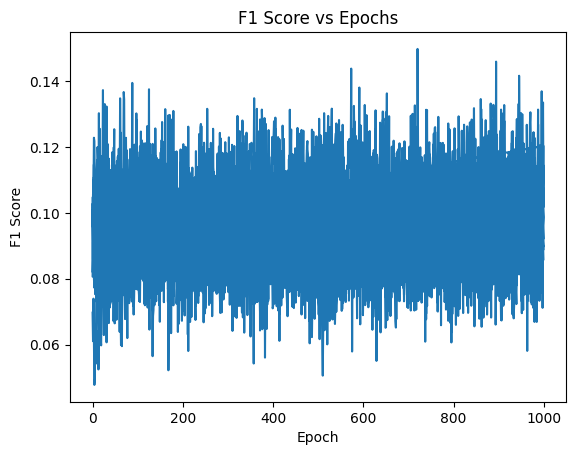

In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from torchsummary import summary


#Define Dataset
# Encode y_train using LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)


# Convert X_train_selected and X_test_selected to a tensor
X_train_np = X_train.values
X_test_np = X_test.values
# X_train_np = X_train.values
# X_test_np = X_test.values
X_train_torch = torch.tensor(X_train_np).float().requires_grad_(True)
X_test_torch = torch.tensor(X_test_np).float().requires_grad_(True)
m,n=X_train_torch.shape

# Convert y_train_encoded and y_test_encoded to a tensor
y_train_torch = torch.tensor(y_train_encoded).long()
y_test_torch = torch.tensor(y_test_encoded).long()


# Define the DNN model
class DNNModel(nn.Module):
    def __init__(self, n, n_hidden, n_output, dropout_rate, l2_lambda):
        super(DNNModel, self).__init__()
        self.n = n
        self.n_hidden = n_hidden
        self.n_output = n_output
        self.dropout_rate = dropout_rate
        self.l2_lambda = l2_lambda
        
        # Define layers
        self.fc1 = nn.Linear(self.n, self.n_hidden)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(self.dropout_rate)
        self.fc2 = nn.Linear(self.n_hidden, self.n_hidden)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(self.dropout_rate)
        self.fc3 = nn.Linear(self.n_hidden, self.n_output)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x
    
    def l2_regularization(self):
        l2_reg = 0.0
        for param in self.parameters():
            l2_reg += torch.norm(param)**2
        return l2_reg

# Define the bootstrapping function
def bootstrap(X, y, n_bootstraps):
    X_bootstraps = []
    y_bootstraps = []
    for i in range(n_bootstraps):
        idxs = np.random.choice(range(len(X)), size=len(X), replace=True)
        X_bootstraps.append(X[idxs])
        y_bootstraps.append(y[idxs])
    return X_bootstraps, y_bootstraps

# Define hyperparameters
n_inputs = n
n_hidden = 30
n_output = 10
dropout_rate = 0.2
l2_lambda = 0.001
n_epochs = 1000
batch_size = 128
learning_rate = 0.001



# Define the model, criterion, optimizer, and learning rate
model = DNNModel(n_inputs, n_hidden, n_output, dropout_rate, l2_lambda)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

# Print model summary
summary(model, (n_inputs,))

model.eval()

# Train the model using bootstrapping
n_bootstraps = 10
X_bootstraps, y_bootstraps = bootstrap(X_train_torch, y_train_torch, n_bootstraps)

# Define empty lists to store F1 scores and epochs
f1_scores = []
epochs = []

for i in range(n_bootstraps):
    X_train_boot = X_bootstraps[i]
    y_train_boot = y_bootstraps[i]
    dataset = TensorDataset(X_train_boot, y_train_boot)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    for epoch in range(n_epochs):
        model.train()
        # Calculate F1 score for this epoch
        y_pred = model(X_test_torch).detach().numpy()
        y_pred = np.argmax(y_pred, axis=1)
        f1 = f1_score(y_test_torch, y_pred, average='weighted')
        
        # Add F1 score and epoch to lists
        f1_scores.append(f1)
        epochs.append(epoch)

        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss += l2_lambda * model.l2_regularization()
            loss.backward(retain_graph=True)
            optimizer.step()
            # Print training loss every 10 epochs
            if (epoch+1) % 10 == 0:
                print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, n_epochs, loss.item()))

# Plot F1 scores against epochs
plt.plot(epochs, f1_scores)
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Epochs')
plt.show()



In [76]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    outputs = model(X_test_torch)
    predicted = torch.argmax(outputs, dim=1)
    print(classification_report(y_test_torch.numpy(), predicted.numpy()))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        36
           1       0.00      0.00      0.00        36
           2       0.00      0.00      0.00        33
           3       0.00      0.00      0.00        23
           4       0.09      0.32      0.14        38
           5       0.00      0.00      0.00        26
           6       0.10      0.17      0.13        53
           7       0.00      0.00      0.00        33
           8       0.14      0.02      0.04        49
           9       0.14      0.34      0.20        58

    accuracy                           0.11       385
   macro avg       0.05      0.09      0.05       385
weighted avg       0.06      0.11      0.07       385



c:\Users\Mervin\Desktop\Python\Assignment2\.conda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mervin\Desktop\Python\Assignment2\.conda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mervin\Desktop\Python\Assignment2\.conda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

In [68]:
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn

writer = SummaryWriter('runs')
writer.add_graph(model, (torch.zeros([1, n_inputs]), ))
writer.close()